In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from pyCompare import blandAltman

test_path = "../results/hold-out-test.csv"
val_path = "../results/internal-val-data.csv"

external_all_path = "../results/external-data.csv"
prospective_all_path = "../results/prospective-data.csv"

figureSize = (4, 4)


def dice_plot(
    x,
    y,
    title,
    figureSize=figureSize,
    x_label="Reference htTKV (mL)",
    y_label="Dice Similarity Coefficient",
):

    dpi = 72
    fig, ax = plt.subplots(figsize=figureSize, dpi=dpi)
    draw = True
    medianColour = "#6495ED"
    loaColour = "coral"
    pointColour = "#6495ED"

    ax.scatter(x, y, alpha=0.5, c=pointColour)

    median = np.median(y)

    # First quartile (Q1)
    Q1 = np.percentile(y, 25, interpolation = 'midpoint')
    # Third quartile (Q3)
    Q3 = np.percentile(y, 75, interpolation = 'midpoint')

    iqr = Q3 - Q1
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    print(f"lenth={len(y)} \n{np.sort(y)} \nQ1={Q1:.4f}, Q3={Q3:.4f}")


    offset = 0.03
    ax.text(
        0.97,
        Q1 - 2 * offset,
        f"median {median:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        Q1 - 3 * offset,
        f"IQR (Q1 to Q3)= {iqr:.2f}",
        ha="right",
        va="bottom",
        transform=trans,
    )
    ax.text(
        0.97,
        Q1 - 4 * offset,
        f"IQR in coral",
        ha="right",
        va="bottom",
        transform=trans,
    )

    ax.axhspan(Q1, Q3, facecolor=loaColour, alpha=0.2)

    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, pad=10)
    ax.set_ylim([0.7, 1.02])
    ax.axhline(np.median(y), color=medianColour, linestyle="--")

    ax.set_yticks(np.arange(0.7, 1.0, 0.05))



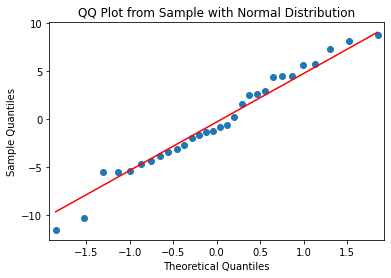

In [2]:
# QQ Plot
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(30)
# q-q plot
qqplot(data, line='s')
plt.title("QQ Plot from Sample with Normal Distribution")
pyplot.show()

In [3]:
import scipy.stats as st

def confidence_int(data):
    return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 


In [4]:
# external_ds = pd.read_csv(external_path)
# prospective_ds = pd.read_csv(prospective_path)
prospective_ds = pd.read_csv(prospective_all_path)
prospective_ds.TKV_Pred /= 1000  # corrects units to mL
prospective_ds.TKV_GT /= 1000  # corrects units to mL

test_ds = pd.read_csv(test_path)
test_ds.TKV_GT /= 1000  # corrects units to mL
test_ds.TKV_Pred /= 1000  # corrects units to mL


external_ds = pd.read_csv(external_all_path)

val_ds = pd.read_csv(val_path)
val_ds.TKV_GT /= 1000  # corrects units to mL
val_ds.TKV_Pred /= 1000  # corrects units to mL



# Prospective

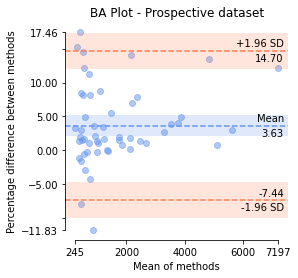

In [5]:

blandAltman(
    prospective_ds.TKV_GT,
    prospective_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Prospective dataset",
    figureSize=figureSize,
)

Mean difference (Prospective)= 3.629
SD (Prospective)= 5.650
1.96 * SD (Prospective)= 11.07


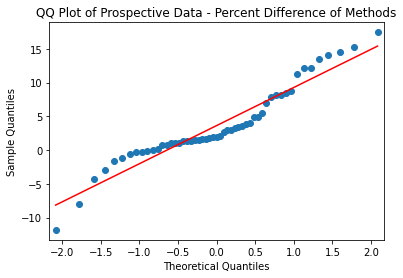

In [6]:
mean = np.mean([prospective_ds.TKV_GT, prospective_ds.TKV_Pred], axis=0)
diff = ((prospective_ds.TKV_GT - prospective_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Prospective)= {md:.3f}")
print(f"SD (Prospective)= {sd:.3f}")
print(f"1.96 * SD (Prospective)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot of Prospective Data - Percent Difference of Methods")
pyplot.show()

In [7]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1

  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.79, 6.97) = 6.18
Median = 1.98


In [8]:
confidence_int(diff)

(2.0570455788989217, 5.2013535763903604)

# External

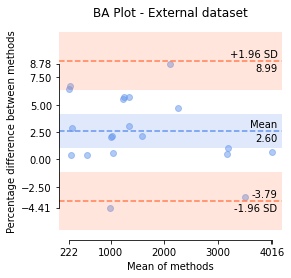

In [9]:
blandAltman(
    external_ds.TKV_GT,
    external_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - External dataset",
    figureSize=figureSize,
)

Mean difference (External)= 2.598
SD (External)= 3.260
1.96 * SD (External)= 6.39


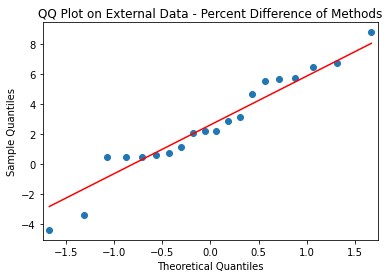

In [10]:
mean = np.mean([external_ds.TKV_GT, external_ds.TKV_Pred], axis=0)
diff = ((external_ds.TKV_GT - external_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (External)= {md:.3f}")
print(f"SD (External)= {sd:.3f}")
print(f"1.96 * SD (External)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on External Data - Percent Difference of Methods")
pyplot.show()

In [11]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.54, 5.61) = 5.08
Median = 2.18


In [12]:
confidence_int(diff)

(1.0321184291487318, 4.16307855656116)

# Internal Hold-out Test

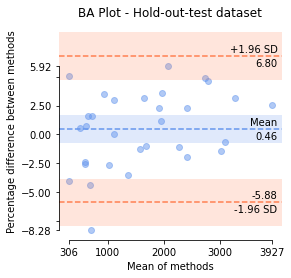

In [13]:
blandAltman(
    test_ds.TKV_GT,
    test_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Hold-out-test dataset",
    figureSize=figureSize,
)



Mean difference (Hold-out)= 0.461
SD (Hold-out)= 3.235
1.96 * SD (Hold-out)= 6.34


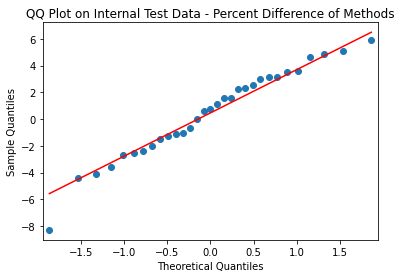

In [14]:
mean = np.mean([test_ds.TKV_GT, test_ds.TKV_Pred], axis=0)
diff = ((test_ds.TKV_GT - test_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Hold-out)= {md:.3f}")
print(f"SD (Hold-out)= {sd:.3f}")
print(f"1.96 * SD (Hold-out)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Test Data - Percent Difference of Methods")
pyplot.show()

In [15]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (-1.73, 3.07) = 4.80
Median = 0.77


# Internal Val

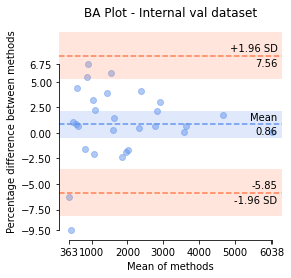

In [16]:
blandAltman(
    val_ds.TKV_GT,
    val_ds.TKV_Pred,
    percentage=True,
    title="BA Plot - Internal val dataset",
    figureSize=figureSize,
)


Mean difference (Internal Val)= 0.855
SD (Internal Val)=  3.420
1.96 * SD (Internal Val)= 6.70


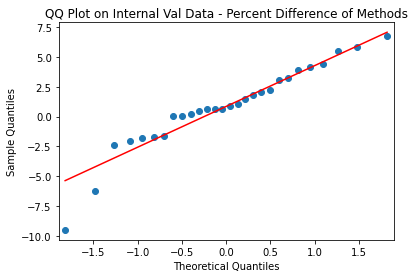

In [17]:
mean = np.mean([val_ds.TKV_GT, val_ds.TKV_Pred], axis=0)
diff = ((val_ds.TKV_GT - val_ds.TKV_Pred) / mean) * 100
md = np.mean(diff)
sd = np.std(diff)
print(f"Mean difference (Internal Val)= {md:.3f}")
print(f"SD (Internal Val)=  {sd:.3f}")
print(f"1.96 * SD (Internal Val)= {1.96 * sd:.2f}")

qqplot(diff, line='s')
plt.title("QQ Plot on Internal Val Data - Percent Difference of Methods")
pyplot.show()

In [18]:
# First quartile (Q1)
Q1 = np.percentile(diff, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(diff, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.2f}, {Q3:.2f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (-0.78, 3.15) = 3.94
Median = 0.79


In [19]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)

# Dice Plots

## Prospective


lenth=53 
[0.79800983 0.90494795 0.91011701 0.91889837 0.91931908 0.92143764
 0.9215194  0.92390174 0.92900675 0.9311488  0.93223751 0.93385743
 0.93616875 0.9367174  0.93801304 0.94869632 0.94889126 0.95300649
 0.95347923 0.95947051 0.95998746 0.96049446 0.96450358 0.96732084
 0.96741238 0.96971307 0.97081322 0.97176903 0.97244007 0.97252493
 0.97460467 0.97570051 0.97655521 0.97887356 0.97921155 0.98081061
 0.98147983 0.98249536 0.98408875 0.98425069 0.98553753 0.98637077
 0.98666073 0.98871064 0.99105194 0.99130425 0.99146448 0.99174941
 0.99192493 0.99232368 0.99440742 0.9949051  0.99652141] 
Q1=0.9367, Q3=0.9843


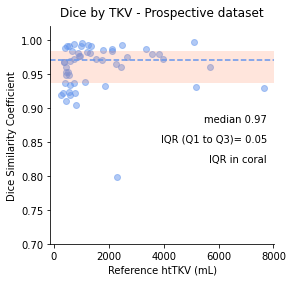

In [20]:
dice_plot(
    prospective_ds.TKV_GT,
    prospective_ds.patient_dice,
    title="Dice by TKV - Prospective dataset",
    figureSize=figureSize,
)

In [21]:
# First quartile (Q1)
Q1 = np.percentile(prospective_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(prospective_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.3f}, {Q3:.3f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.937, 0.984) = 0.05
Median = 0.79


In [22]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)

## External

lenth=20 
[0.89260231 0.90881927 0.95366038 0.96186072 0.96412663 0.96555127
 0.96756603 0.96839013 0.9710493  0.97227819 0.98272089 0.9833348
 0.98861437 0.98883498 0.98916972 0.99017556 0.99018741 0.9945441
 0.99585999 0.99788788] 
Q1=0.9648, Q3=0.9897


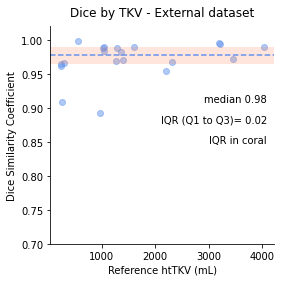

In [23]:
dice_plot(
    external_ds.TKV_GT,
    external_ds.patient_dice,
    title="Dice by TKV - External dataset",
    figureSize=figureSize,
)

In [24]:
# First quartile (Q1)
Q1 = np.percentile(external_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(external_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.3f}, {Q3:.3f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.965, 0.990) = 0.02
Median = 0.79


In [25]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)

## Hold-Out Test

lenth=31 
[0.82657147 0.87560976 0.91879124 0.93063009 0.93177122 0.9335795
 0.93460387 0.93818039 0.93972212 0.94179243 0.94186872 0.94359148
 0.94426328 0.94482636 0.94640189 0.94658738 0.94692731 0.94930077
 0.9494375  0.95211929 0.95345038 0.9548415  0.95790404 0.95833278
 0.9630397  0.96421957 0.96492755 0.96528    0.96601415 0.96613389
 0.9832921 ] 
Q1=0.9390, Q3=0.9581


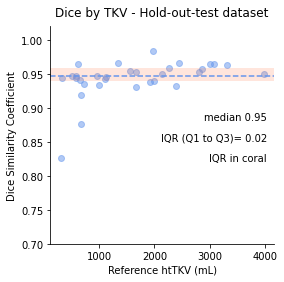

In [26]:
dice_plot(
    test_ds.TKV_GT,
    test_ds.patient_dice,
    title="Dice by TKV - Hold-out-test dataset",
    figureSize=figureSize,
)

In [27]:
# First quartile (Q1)
Q1 = np.percentile(test_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(test_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.3f}, {Q3:.3f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.939, 0.958) = 0.02
Median = 0.79


In [28]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)

## Internal Val

lenth=28 
[0.89370698 0.92839074 0.92984551 0.93112946 0.93285096 0.93437773
 0.93448436 0.93570805 0.93678617 0.93760186 0.94232631 0.94456857
 0.95010048 0.95246571 0.95329368 0.95379746 0.95669061 0.95768982
 0.95959389 0.95968825 0.96000874 0.96185243 0.96454376 0.96518075
 0.96563059 0.96809256 0.97292078 0.97377849] 
Q1=0.9351, Q3=0.9609


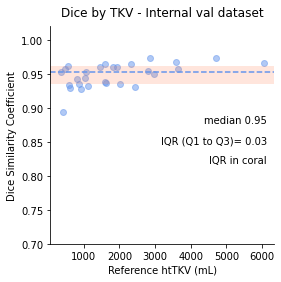

In [29]:
dice_plot(
    val_ds.TKV_GT,
    val_ds.patient_dice,
    title="Dice by TKV - Internal val dataset",
    figureSize=figureSize,
)

In [30]:
# First quartile (Q1)
Q1 = np.percentile(val_ds.patient_dice, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(val_ds.patient_dice, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(f"IQRs (25, 75) = ({Q1:.3f}, {Q3:.3f}) = {IQR:.2f}")
print(f"Median = {np.median(diff):.2f}")

IQRs (25, 75) = (0.935, 0.961) = 0.03
Median = 0.79


In [31]:
confidence_int(diff)

(-0.49548351328945117, 2.205567132770493)